In [1]:
import json
import numpy as np
import cv2
from glob import glob
from os.path import join as pjoin
from tqdm import tqdm

In [16]:
def resize_label(bboxes, d_height, gt_height, bias=0):
    bboxes_new = []
    scale = gt_height/d_height
    for bbox in bboxes:
        bbox = [int(b * scale + bias) for b in bbox]
        bboxes_new.append(bbox)
    return bboxes_new


def draw_bounding_box(org, corners, color=(0, 255, 0), line=2, show=False):
    board = org.copy()
    for i in range(len(corners)):
        board = cv2.rectangle(board, (corners[i][0], corners[i][1]), (corners[i][2], corners[i][3]), color, line)
    if show:
        cv2.imshow('a', cv2.resize(board, (500, 1000)))
        cv2.waitKey(0)
    return board


def load_detect_result_json(reslut_file_root, shrink=0):
    def is_bottom_or_top(corner):
        column_min, row_min, column_max, row_max = corner
        if row_max < 36 or row_min > 725:
            return True
        return False

    result_files = glob(pjoin(reslut_file_root, '*.json'))
    compos_reform = {}
    print('Loading %d detection results' % len(result_files))
    for reslut_file in tqdm(result_files):
        img_name = reslut_file.split('\\')[-1].split('.')[0]
        compos = json.load(open(reslut_file, 'r'))['compos']
        for compo in compos:
            if is_bottom_or_top((compo['column_min'], compo['row_min'], compo['column_max'], compo['row_max'])):
                continue
            if img_name not in compos_reform:
                compos_reform[img_name] = {'bboxes': [[compo['column_min'] + shrink, compo['row_min'] + shrink, compo['column_max'] - shrink, compo['row_max'] - shrink]],
                                           'categories': [compo['category']]}
            else:
                compos_reform[img_name]['bboxes'].append([compo['column_min'] + shrink, compo['row_min'] + shrink, compo['column_max'] - shrink, compo['row_max'] - shrink])
                compos_reform[img_name]['categories'].append(compo['category'])
    return compos_reform


def load_ground_truth_json(gt_file):
    def get_img_by_id(img_id):
        for image in images:
            if image['id'] == img_id:
                return image['file_name'].split('/')[-1][:-4], (image['height'], image['width'])

    def cvt_bbox(bbox):
        '''
        :param bbox: [x,y,width,height]
        :return: [col_min, row_min, col_max, row_max]
        '''
        bbox = [int(b) for b in bbox]
        return [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]

    data = json.load(open(gt_file, 'r'))
    images = data['images']
    annots = data['annotations']
    compos = {}
    print('Loading %d ground truth' % len(annots))
    for annot in tqdm(annots):
        img_name, size = get_img_by_id(annot['image_id'])
        if img_name not in compos:
            compos[img_name] = {'bboxes': [cvt_bbox(annot['bbox'])], 'categories': [annot['category_id']], 'size':size}
        else:
            compos[img_name]['bboxes'].append(cvt_bbox(annot['bbox']))
            compos[img_name]['categories'].append(annot['category_id'])
    return compos


def eval(detection, ground_truth, img_root, show=True, no_text=False, only_text=False):

    def compo_filter(compos, flag):
        if not no_text and not only_text:
            return compos
        compos_new = {'bboxes':[], 'categories':[]}
        for k, category in enumerate(compos['categories']):
            if only_text:
                if flag == 'det' and category != 'TextView':
                    continue
                if flag == 'gt' and int(category) != 14:
                    continue
            elif no_text:
                if flag == 'det' and category == 'TextView':
                    continue
                if flag == 'gt' and int(category) == 14:
                    continue

            compos_new['bboxes'].append(compos['bboxes'][k])
            compos_new['categories'].append(category)
        return compos_new

    def match(org, d_bbox, gt_bboxes, matched):
        '''
        :param matched: mark if the ground truth component is matched
        :param d_bbox: [col_min, row_min, col_max, row_max]
        :param gt_bboxes: list of ground truth [[col_min, row_min, col_max, row_max]]
        :return: Boolean: if IOU large enough or detected box is contained by ground truth
        '''
        area_d = (d_bbox[2] - d_bbox[0]) * (d_bbox[3] - d_bbox[1])
        for i, gt_bbox in enumerate(gt_bboxes):
            if matched[i] == 0:
                continue
            area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
            col_min = max(d_bbox[0], gt_bbox[0])
            row_min = max(d_bbox[1], gt_bbox[1])
            col_max = min(d_bbox[2], gt_bbox[2])
            row_max = min(d_bbox[3], gt_bbox[3])
            # if not intersected, area intersection should be 0
            w = max(0, col_max - col_min)
            h = max(0, row_max - row_min)
            area_inter = w * h
            if area_inter == 0:
                continue
            iod = area_inter / area_d
            iou = area_inter / (area_d + area_gt - area_inter)
            # if show:
            #     cv2.putText(org, (str(round(iou, 2)) + ',' + str(round(iod, 2))), (d_bbox[0], d_bbox[1]),
            #                 cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            if iou > 0.9 or iod == 1:
                matched[i] = 0
                return True
        return False

    amount = len(detection)
    TP, FP, FN = 0, 0, 0
    pres, recalls = [], []
    for i, image_id in enumerate(detection):
        TP_this, FP_this, FN_this = 0, 0, 0
        img = cv2.imread(pjoin(img_root, image_id + '.jpg'))
        d_compos = detection[image_id]
        gt_compos = ground_truth[image_id]

        org_height = gt_compos['size'][0]

        d_compos = compo_filter(d_compos, 'det')
        gt_compos = compo_filter(gt_compos, 'gt')

        d_compos['bboxes'] = resize_label(d_compos['bboxes'], 800, org_height)
        matched = np.ones(len(gt_compos['bboxes']), dtype=int)
        for d_bbox in d_compos['bboxes']:
            if match(img, d_bbox, gt_compos['bboxes'], matched):
                TP += 1
                TP_this += 1
            else:
                FP += 1
                FP_this += 1
        FN += sum(matched)
        FN_this = sum(matched)
        
        try:
            pre_this = TP_this / (TP_this + FP_this)
            recall_this = TP_this / (TP_this + FN_this)
        except:
            print('empty')
            continue
    
        pres.append(pre_this)
        recalls.append(recall_this)
        if show:
            print(image_id + '.jpg')
            print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (
            i, amount, TP_this, FP_this, FN_this, pre_this, recall_this))
            cv2.imshow('org', cv2.resize(img, (500, 1000)))
            broad = draw_bounding_box(img, d_compos['bboxes'], color=(255, 0, 0), line=3)
            draw_bounding_box(broad, gt_compos['bboxes'], color=(0, 0, 255), show=True, line=2)

        if i % 200 == 0:
            precesion = TP / (TP + FP)
            recall = TP / (TP + FN)
            print(
                '[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (i, amount, TP, FP, FN, precesion, recall))

    precesion = TP / (TP + FP)
    recall = TP / (TP + FN)
    print('[%d/%d] TP:%d, FP:%d, FN:%d, Precesion:%.3f, Recall:%.3f' % (i, amount, TP, FP, FN, precesion, recall))
    # print("Average precision:%.4f; Average recall:%.3f" % (sum(pres)/len(pres), sum(recalls)/len(recalls)))

    return pres, recalls

In [24]:
detect = load_detect_result_json('E:\\Mulong\\Result\\rico\\rico_uied\\rico_new_uied_cls\\merge')

  0%|▎                                                                              | 22/4708 [00:00<00:24, 190.91it/s]

Loading 4708 detection results


100%|█████████████████████████████████████████████████████████████████████████████| 4708/4708 [00:05<00:00, 821.76it/s]


In [25]:
gt = load_ground_truth_json('E:\\Mulong\\Datasets\\rico\\instances_test.json')

  9%|██████▎                                                                   | 7386/86646 [00:00<00:01, 73333.97it/s]

Loading 86646 ground truth


100%|██████████████████████████████████████████████████████████████████████████| 86646/86646 [00:17<00:00, 5031.08it/s]


In [18]:
no_text = False
only_text = False
pres_all, recalls_all = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False, no_text=no_text, only_text=only_text)

[0/4707] TP:1, FP:2, FN:3, Precesion:0.333, Recall:0.250
[200/4707] TP:2255, FP:2848, FN:1383, Precesion:0.442, Recall:0.620
[400/4707] TP:4538, FP:5843, FN:2666, Precesion:0.437, Recall:0.630
[600/4707] TP:6816, FP:9037, FN:4133, Precesion:0.430, Recall:0.623
[800/4707] TP:9216, FP:11613, FN:5703, Precesion:0.442, Recall:0.618
[1000/4707] TP:11479, FP:14514, FN:7155, Precesion:0.442, Recall:0.616
[1200/4707] TP:13617, FP:17648, FN:8428, Precesion:0.436, Recall:0.618
[1400/4707] TP:15860, FP:20690, FN:9849, Precesion:0.434, Recall:0.617
[1600/4707] TP:18138, FP:23757, FN:11365, Precesion:0.433, Recall:0.615
[1800/4707] TP:20483, FP:26504, FN:13261, Precesion:0.436, Recall:0.607
[2000/4707] TP:22965, FP:29465, FN:14625, Precesion:0.438, Recall:0.611
[2200/4707] TP:25266, FP:32578, FN:15847, Precesion:0.437, Recall:0.615
[2400/4707] TP:27706, FP:35461, FN:17613, Precesion:0.439, Recall:0.611
[2600/4707] TP:29935, FP:38268, FN:19119, Precesion:0.439, Recall:0.610
[2800/4707] TP:32130, FP:

In [26]:
no_text = True
only_text = False
pres_non_text, recalls_non_text = eval(detect, gt, 'E:\\Mulong\\Datasets\\rico\\combined', show=False, no_text=no_text, only_text=only_text)

[0/4707] TP:1, FP:0, FN:0, Precesion:1.000, Recall:1.000
empty
empty
[200/4707] TP:935, FP:1871, FN:765, Precesion:0.333, Recall:0.550
empty
empty
[400/4707] TP:1929, FP:4023, FN:1473, Precesion:0.324, Recall:0.567
[600/4707] TP:2911, FP:6300, FN:2306, Precesion:0.316, Recall:0.558
[800/4707] TP:3854, FP:8080, FN:3141, Precesion:0.323, Recall:0.551
empty
[1000/4707] TP:4741, FP:10119, FN:3973, Precesion:0.319, Recall:0.544
empty
empty
[1200/4707] TP:5635, FP:12354, FN:4772, Precesion:0.313, Recall:0.541
empty
empty
empty
[1400/4707] TP:6544, FP:14558, FN:5566, Precesion:0.310, Recall:0.540
empty
[1600/4707] TP:7463, FP:16654, FN:6341, Precesion:0.309, Recall:0.541
[1800/4707] TP:8311, FP:18777, FN:7359, Precesion:0.307, Recall:0.530
empty
[2000/4707] TP:9390, FP:20981, FN:8060, Precesion:0.309, Recall:0.538
empty
[2200/4707] TP:10394, FP:23233, FN:8772, Precesion:0.309, Recall:0.542
empty
[2400/4707] TP:11343, FP:25276, FN:9683, Precesion:0.310, Recall:0.539
empty
[2600/4707] TP:12261,

In [20]:
import matplotlib.pyplot as plt

def draw_plot(data):
    fig = plt.figure()  # 创建画布
    ax = plt.subplot()  # 创建作图区域
    ax.boxplot([d for d in data])
    ax.set_xticklabels(['precisions', 'recalls'])
    plt.grid(axis='y')
    fig.show()

D:\Anaconda\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


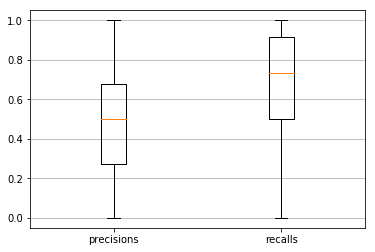

In [22]:
draw_plot([pres_all, recalls_all])

D:\Anaconda\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


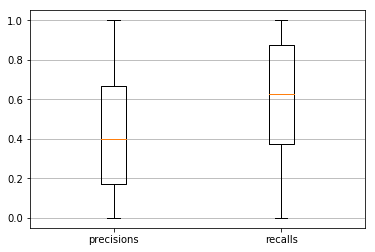

In [27]:
draw_plot([pres_non_text, recalls_non_text])